# 1 导入所需模块

In [4]:
import numpy as np
import tensorflow as tf
from collections import Counter
import os

# 2 预处理语句

#### 读取文本文件

In [5]:
def _read_words(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read().replace('\n', '<eos>').split()

#### 分词成list并赋予id
通过字典的方法，将单词进行编号，并记录词频，根据词频对单词进行排序，一定程度上可以降低计算复杂度（低概率词的id较大）。

In [6]:
def _build_vocab(filename):
    data = _read_words(filename)

    counter = Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: -x[1])

    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))

    return words, word_to_id

#### 读取文件对应的id

In [7]:
def _file_to_word_ids(filename, word_to_id):
    data = _read_words(filename)
    return [word_to_id[x] for x in data if x in word_to_id]

#### 将id序列转化为句子
通过id字典将数字转化为单词，有利于文本输出，本作业中并未用到。

In [8]:
def to_words(sentence, words):
    return list(map(lambda x: words[x], sentence))

#### 生成训练与验证数据
通过对文字的数字化，形成data文件，data文件为一串长字符串

In [9]:
def _raw_data(data_path):
    train_path = os.path.join(data_path, 'train.txt')
    valid_path = os.path.join(data_path, 'valid.txt')
    test_path = os.path.join(data_path, 'test.txt')

    words, word_to_id = _build_vocab(train_path)
    train_data = _file_to_word_ids(train_path, word_to_id)
    valid_data = _file_to_word_ids(valid_path, word_to_id)
    test_data = _file_to_word_ids(test_path, word_to_id)

    return train_data, valid_data, test_data, words, word_to_id

#### 产生训练batch
通过对data字符串(如train_data)按照num_steps进行分句，同时采用batch_size进行batch分组，最后形成x和y分别为(batch_len,batch_size*num_steps)长度的tensor

In [10]:
def _producer(raw_data, batch_size=64, num_steps=20, stride=1):
    data_len = len(raw_data)

    sentences = []
    next_words = []
    for i in range(0, data_len - num_steps, stride):
        sentences.append(raw_data[i:(i + num_steps)])
        next_words.append(raw_data[i + num_steps])

    sentences = np.array(sentences)
    next_words = np.array(next_words)

    batch_len = len(sentences) // batch_size
    x = np.reshape(sentences[:(batch_len * batch_size)], \
        [batch_len, batch_size, -1])

    y = np.reshape(next_words[:(batch_len * batch_size)], \
        [batch_len, batch_size])

    return x, y

# 3 构建模型
### 模型参数
通过config管理模型的超参数，方便调试。

In [12]:
class LMConfig(object):
    """language model 配置项"""
    batch_size = 64       # 每一批数据的大小
    num_steps = 20        # 每一个句子的长度
    stride = 3            # 取数据时的步长
    vocab_size = 10000       # 词汇表大小
    max_grad_norm = 5
    embedding_dim = 64    # 词向量维度
    hidden_dim = 300      # RNN隐藏层维度
    num_layers = 2        # RNN层数

    learning_rate = 0.05  # 学习率
    dropout = 0.8         # 每一层后的丢弃概率
    rnn_model = 'gru'

### 读取数据
对producer函数产生的x，y数据按照batch_size大小进行截取,同时对y数据进行one-hot编码。

In [13]:
class _Input(object):
    """按批次读取数据"""
    def __init__(self, config, data):
        self.batch_size = config.batch_size
        self.num_steps = config.num_steps
        self.vocab_size = config.vocab_size # 词汇表大小

        self.input_data, self.targets = _producer(data,
            self.batch_size, self.num_steps)

        self.batch_len = self.input_data.shape[0] # 总批次
        self.cur_batch = 0  # 当前批次

    def next_batch(self):
        """读取下一批次"""
        x = self.input_data[self.cur_batch]
        y = self.targets[self.cur_batch]

        # 转换为one-hot编码
        y_ = np.zeros((y.shape[0], self.vocab_size), dtype=np.bool)
        for i in range(y.shape[0]):
            y_[i][y[i]] = 1

        # 如果到最后一个批次，则回到最开头
        self.cur_batch = (self.cur_batch +1) % self.batch_len

        return x, y_

### 模型——LSTM
LSTM模型通过tf.contrib.rnn.BasicLSTMCell函数生成LSTM cell，cell的输入数据需要转化成embedding，通过tf.nn.embedding_lookup函数生成可用的input，构建rnn网络，通过dropout保证模型不会过拟合。建立多层rnn模型，通过tf.contrib.rnn.MultiRNNCell将多个lstm cell组合在一起。构建好模型之后，输入input得到output，则logits=tt.matmul(output,softmax_w)+softmax_b，提取模型的梯度grads, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tvars), config.max_grad_norm)以及采用梯度下降优化器optimizer = tf.train.GradientDescentOptimizer(learning_rate=config.learning_rate)，在实际跑程序是，通过对learning_rate的动态调整，从而加速优化，参考PTB代码中的指数下降方法，即到达一定epoch时，learning_rate呈指数下降。

In [14]:
class Model(object):
    def __init__(self, config, is_training=True):

        self.num_steps = config.num_steps
        self.vocab_size = config.vocab_size

        self.embedding_dim = config.embedding_dim
        self.hidden_dim = config.hidden_dim
        self.num_layers = config.num_layers
        self.rnn_model = config.rnn_model

        self.learning_rate = config.learning_rate
        self.dropout = config.dropout
        

        self.placeholders()  # 输入占位符
        self.rnn()           # rnn 模型构建
        self.error()         # 错误率


    def placeholders(self):
        """输入数据的占位符"""
        self._inputs = tf.placeholder(tf.int32, [self.batch_size, self.num_steps])
        self._targets = tf.placeholder(tf.int32, [self.batch_size, self.vocab_size])
        self.dropout = tf.placeholder(tf.float32)

    def input_embedding(self):
        """将输入转换为词向量表示"""
        with tf.device("/cpu:0"):
            embedding = tf.get_variable(
                "embedding", [self.vocab_size,
                    self.embedding_dim], dtype=tf.float32)
            _inputs = tf.nn.embedding_lookup(embedding, self._inputs)

        return _inputs


    def rnn(self):
        """rnn模型构建"""
        def lstm_cell():  # 基本的lstm cell
            return tf.contrib.rnn.BasicLSTMCell(self.hidden_dim,
                state_is_tuple=True)

        def gru_cell():   # gru cell，速度更快
            return tf.contrib.rnn.GRUCell(self.hidden_dim)

        def dropout_cell():    # 在每个cell后添加dropout
            if (self.rnn_model == 'lstm'):
                cell = lstm_cell()
            else:
                cell = gru_cell()
            return tf.contrib.rnn.DropoutWrapper(cell,
                output_keep_prob=self.dropout)

        cells = [dropout_cell() for _ in range(self.num_layers)]
        cell = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple=True)  # 多层rnn
        
        _inputs = self.input_embedding()
        if is_training:
            _inputs = tf.nn.dropout(_inputs,1-self.dropout)
        self._initial_state = cell.zero_state(config.batch_size,tf.float32)
        state = self._initial_state
        _outputs = []
        with tf.variable_scope("RNN"):
            for time_step in range(self.num_steps):
                if time_step > 0:tf.get_variable_scope().reuse_variables()
                (cell_output, state) = cell(_inputs[:, time_step, :], state)
                _outputs.append(cell_output)
        output = tf.reshape(tf.concat(_outputs, 1), [-1, config.hidden_dim])
        softmax_w = tf.get_variable("softmax_w", [self.hidden_dim, self.vocab_size],dtype=tf.float32)
        softmax_b = tf.get_variable("softmax_b", [self.vocab_size],dtype=tf.float32)
        logits = tf.nn.xw_plus_b(output, softmax_w, softmax_b)
        logits = tf.reshape(logits, [self.batch_size, self.num_steps, self.vocab_size])
        loss = tf.contrib.seq2seq.sequence_loss(
            logits,self._targets, 
            tf.ones([self.batch_size, self.num_steps], dtype=tf.float32), 
            average_across_timesteps=False, 
            average_across_batch=True)
        #Update the cost
        self._cost = tf.reduce_sum(loss)
        self._final_state = state
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(tf.gradients(self.cost, tvars), config.max_grad_norm)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=config.learning_rate)
        self.train_op = optimizer.apply_gradients(
            zip(grads, tvars), 
            global_step= tf.train.get_or_create_global_step())
    

### 训练及验证
训练过程主要讲数据接口和feed_dict写好，通过is_training选择进行训练还是验证，当进行验证时，采用tf.no_op使用模型处理input处理valid_data中的RNN识别。计算perplexity作为最终的模型评估手段。

In [17]:
def run_epoch(num_epochs=10):
    config = LMConfig()   # 载入参数

    # 载入源数据，这里只需要训练集
    train_data, valid_data, _, words, word_to_id = _raw_data('/Users/Optimus-Prime/Documents/My_Jupyter/Language Model')
    config.vocab_size = len(words)

    # 数据分批
    input_train = _Input(config, train_data)
    input_valid = _Input(config, valid_data)
    batch_len = input_train.batch_len

    # 构建模型
    model = Model(config)

    # 创建session，初始化变量
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    print('Start training...')
    for epoch in range(num_epochs):  # 迭代轮次
        total_cost = 0
        state = sess.run(model._initial_state)
        for i in range(batch_len):   # 经过多少个batch
            x_batch, y_batch = input_train.next_batch()
            # 取一个批次的数据，运行优化
            feed_dict = {model._inputs: x_batch, model._targets: y_batch, model.dropout: config.dropout}
            cost, state, _ = sess.run([model._cost, model._final_state, model.train_op], feed_dict=feed_dict)
            total_cost += cost
            # 每500个batch，输出一次中间结果
            if i % 500 == 0:
                perplexity = np.exp(total_cost/(i*config.num_steps))
                msg = "Epoch: {0:>3}, batch: {1:>6}, Perplexity: {2:>6.3}"
                print(msg.format(epoch + 1, i + 1, perplexity))

                # 输出验证集结果
                total_cost_v= 0
                for j in range(50):
                    x_v_batch, y_v_batch = input_valid.next_batch()
                    feed_dict_v = {model._inputs: x_v_batch, model._targets: y_v_batch, model.dropout: 1}
                    cost_v, state_v, _ = sess.run([model._cost, model._final_state, tf.no_op()], feed_dict=feed_dict_v)
                    total_cost_v += cost_v
                print('validation perplexity: %.3f',np.exp(total_cost_v/(50*config.num_steps)))
    print('Finish training...')
    saver = tf.train.Saver()
    saver.save(sess,'./model.ckpt')
    sess.close()

In [ ]:
run_epoch(10)

# 4. 结果分析与讨论

本次RNN模型采用了LSTM模型对文本进行分析，通过调整不同的learning_rate对RNN计算结果进行评估如下图所示是learning_rate分别为0.5，0.7,1以及learning_rate从1按照指数衰减情况下，模型训练集perplexity的变化曲线以及验证集的perplexity水平。从训练速度上看 learning_rate越大越容易收敛到临界值，当迭代次数增加是，大约在perplexity到200左右就不再降低，相对而言，递减的learning_rate可以收敛到更低的perplexity。从验证集的表现可以看出，learning_rate越低，验证效果越明显，而指数衰减的learning_rate在验证集上表现最好，这很可能源于其收敛的相对快速性。
最终提交的模型采用指数衰减learning_rate的模型。

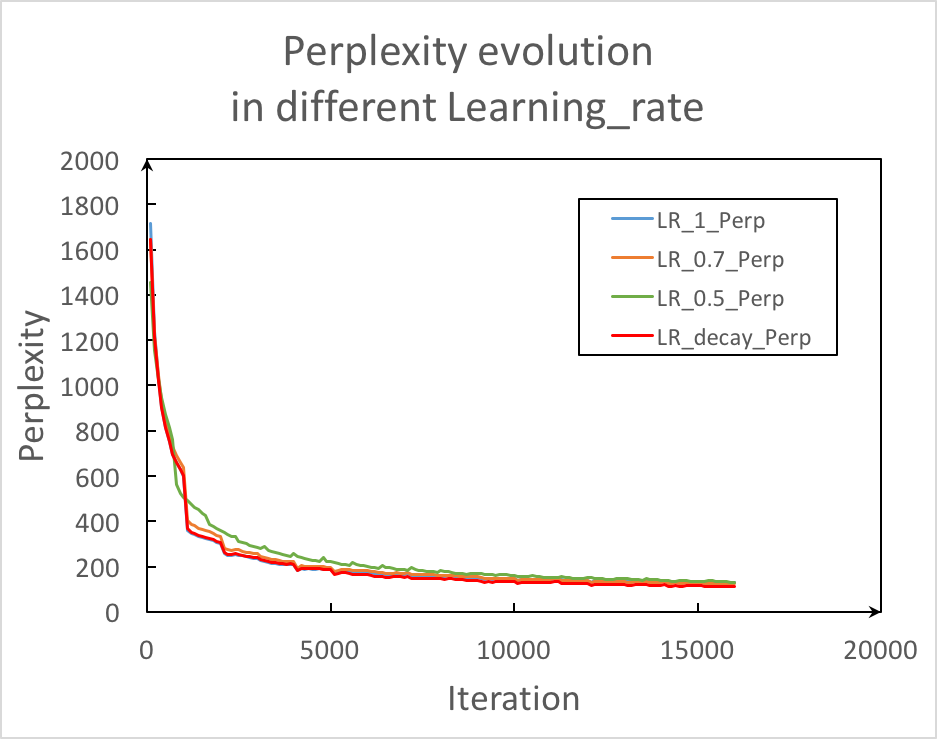

In [20]:
from IPython.display import Image
Image(filename="/Users/Optimus-Prime/Desktop/1.png",width=600,height=400)

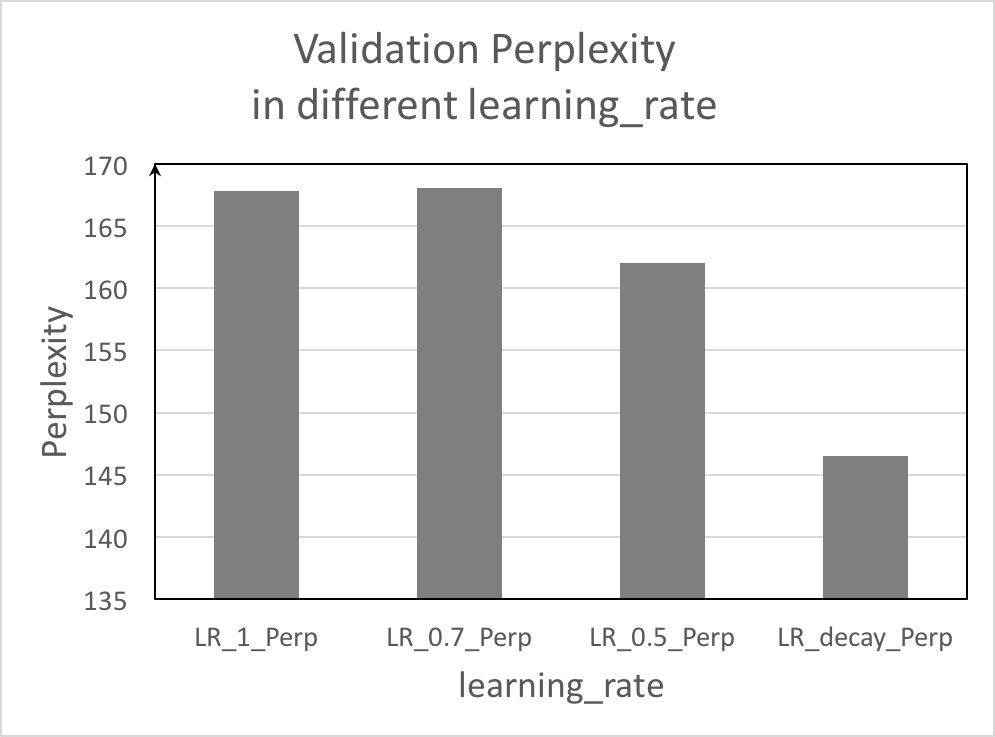

In [21]:
Image(filename="/Users/Optimus-Prime/Desktop/2.png",width=600,height=400)